# Aprendizado por Reforço

- Bruno Pilão - 202201037911
- Mateus Norcia - 202201038381
- Isabelle Mamprim - 202109123289


Este trabalho tem como objetivo aplicar os conceitos fundamentais de Aprendizado por Reforço (Reinforcement Learning) através da modelagem de um Processo de Decisão de Markov (MDP), utilizando o ambiente Taxi-v3 disponível na biblioteca Gymnasium.

O ambiente simula um cenário onde um táxi deve buscar um passageiro em um ponto específico e levá-lo até o destino correto, dentro de um grid (5x5) com obstáculos e paredes. O agente (táxi) aprende a agir por tentativa e erro, buscando maximizar a recompensa acumulada com base nas ações tomadas.

![Ambiente Taxi-v3](img/enviroment_taxi.png)



## 🧩 Definição do Markov Decision Process


### Estados (S):
- O ambiente tem 500 estados possíveis. Cada estado representa:
- Posição do táxi (fila, coluna)
- Local de origem do passageiro (uma das 5 localizações fixas)
    - 0: Vermelho
    - 1: Verde
    - 2: Amarelo
    - 3: Azul
    - 4: No taxi

### Ações (A):
- 0 = Mover para sul
- 1 = Mover para norte
- 2 = Mover para leste
- 3 = Mover para oeste
- 4 = Pegar passageiro
- 5 = Deixar passageiro

### Recompensas
- R(s, a) = −1 por passo.
- Estados (0,1);(0,4);(4,1);(3,4) são terminais com recompensa +20 (depedendo da Localização do Hotel).
- Estado tem recompensa negativa −10, por executar indevidamente as ações de embarque e desembarque.
### Transições (P(s'|s,a)):
Determinísticas, exceto quando o táxi tenta atravessar uma parede, nesse caso, ele permanece no mesmo estado.

### Recompensas

- -1 Movimento do Taxi.
- +20 Despachar passageiro corretamente.
- -10 Buscar / Despachar passageiro corretamente.


In [1]:
!python --version

Python 3.13.9


In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [3]:
# Criando o ambiente Taxi-v3
env_default = gym.make("Taxi-v3",render_mode='rgb_array')
env_raining = gym.make("Taxi-v3",is_rainy=True,render_mode='rgb_array')

In [4]:
# Definindo estados do ambiente
estados=[
 (0, 0), (0, 1), (0, 2), (0, 3), (0, 4),
 (1, 0), (1, 1), (1, 2), (1, 3), (1, 4),
 (2, 0), (2, 1), (2, 2), (2, 3), (2, 4),
 (3, 0), (3, 1), (3, 2), (3, 3), (3, 4),
 (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)
]

#Definindo ações do ambiente
acoes = {
    0: "South ⬇️",
    1: "North ⬆️",
    2: "East ➡️",
    3: "West ⬅️",
    4: "Pickup 🚖",
    5: "Dropoff 🛑"
}

## Equação de Bellman


In [5]:
# Teste de funcao de Bellman
env_default.action_space.n, env_default.observation_space.n

(np.int64(6), np.int64(500))

In [6]:
def aplicar_bellman(env, gamma=0.9, theta=1e-6):
    """
    Aplica a Equação de Bellman (Value Iteration) a um ambiente Gym.
    Retorna V(s) e um DataFrame com o histórico de convergência.
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    V = np.zeros(n_states)
    history = []
    iter_count = 0

    def bellman_update(V):
        delta = 0
        for s in range(n_states):
            v = V[s]
            values = []
            for a in range(n_actions):
                q_sa = 0
                for prob, next_state, reward, done in env.unwrapped.P[s][a]:
                    q_sa += prob * (reward + gamma * V[next_state] * (not done))
                    # print(f"Estado: {s}, Ação: {a}, Próximo Estado: {next_state}, Recompensa: {reward}, Probabilidade: {prob}, Done: {done}")
                values.append(q_sa)
            V[s] = max(values)
            delta = max(delta, abs(v - V[s]))
        
        return V, delta

    while True:
        V, delta = bellman_update(V)
        iter_count += 1
        history.append({
            "Iteracao": iter_count,
            "Valor Médio": np.mean(V),
            "Valor Máximo": np.max(V),
            "Delta": delta,
            "V": V.copy()
            
            
        })
        if delta < theta:
            break

    df = pd.DataFrame(history)
    return df


In [7]:
print("Aplicando Bellman ao ambiente padrão...")    
df_default = aplicar_bellman(env_default)

print("Aplicando Bellman ao ambiente com chuva...")
df_raining = aplicar_bellman(env_raining)

Aplicando Bellman ao ambiente padrão...
Aplicando Bellman ao ambiente com chuva...


## Plots de Visualização


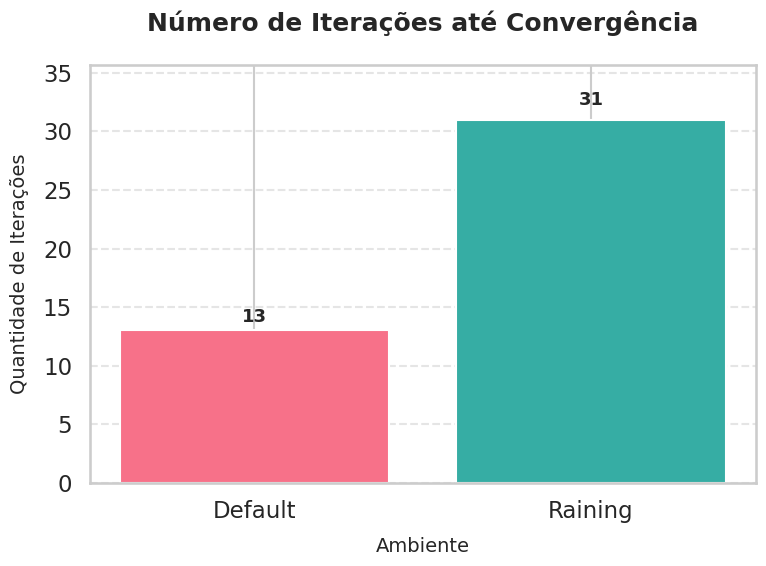

In [8]:
# Configurações visuais consistentes
sns.set_theme(style="whitegrid", context="talk")

# Paleta suave e equilibrada (husl)
palette = sns.color_palette("husl", n_colors=2)

# Criação do gráfico
plt.figure(figsize=(8, 6))
bars = plt.bar(
    ["Default", "Raining"],
    [len(df_default), len(df_raining)],
    color=palette
)

# Título e rótulos
plt.title(
    "Número de Iterações até Convergência",
    fontsize=18,
    pad=25,
    weight="bold",
    loc="center"  
)
plt.xlabel("Ambiente", fontsize=14, labelpad=10)
plt.ylabel("Quantidade de Iterações", fontsize=14, labelpad=10)

# Ajuste no espaçamento dos rótulos acima das barras
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + (0.03 * height),  # pequeno espaçamento vertical
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=13,
        fontweight="bold",
        
    )

# Grade horizontal discreta
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Margem superior adicional para evitar corte visual
plt.margins(y=0.15)
plt.tight_layout()
plt.show()



In [9]:
def plot_evolucao_V(dataset,title):
    """
    Funcao para plotar a evolução de V(s) ao longo dos Iterações
    """

    # Configurações de estilo do seaborn
    sns.set_theme(style="whitegrid", context="talk")

    # Tamanho da figura
    plt.figure(figsize=(22, 10))

    # Paleta clara e equilibrada (husl tem bom contraste)
    palette = sns.color_palette("husl", n_colors=len(dataset))

    # Valor do deslocamento vertical entre Iterações
    offset = 3.0  

    # Plotando cada episódio com suavização e deslocamento
    for i in range(len(dataset)):
        v_raw = pd.Series(dataset["V"][i])
        # suaviza um pouco mais
        v_smooth = v_raw.rolling(window=8, center=True, min_periods=1).mean()

        # aplica deslocamento vertical para separar visualmente as curvas
        v_data = pd.DataFrame({
            "Estado": range(len(v_smooth)),
            "Valor": v_smooth + (i * offset)
        })

        sns.lineplot(
            data=v_data,
            x="Estado",
            y="Valor",
            color=palette[i],
            linewidth=2.0,
            alpha=0.75,
            label=f"Episódio {i+1}"
        )


    # Customizações 
    plt.title(f"Evolução de V(s) — Ambiente {title} ", fontsize=22, pad=25, weight="bold")
    plt.xlabel("Estado (s)", fontsize=16)
    plt.ylabel("Valor de V(s) (com deslocamento visual)", fontsize=16)

    # Legenda lateral organizada
    plt.legend(
        title="Iterações",
        bbox_to_anchor=(1,1),
        loc='upper left',
        fontsize=12,
        frameon=True,
        framealpha=0.9
    )

    # Grade e espaçamento
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.margins(y=0.1)
    plt.tight_layout()
    plt.show()
    
    # Printando valor medio por episodio
    for i in range(len(dataset)):
        print(f"Iteração {i+1}: Valor médio de V(s) = {dataset['Valor Médio'][i]:.4f}")


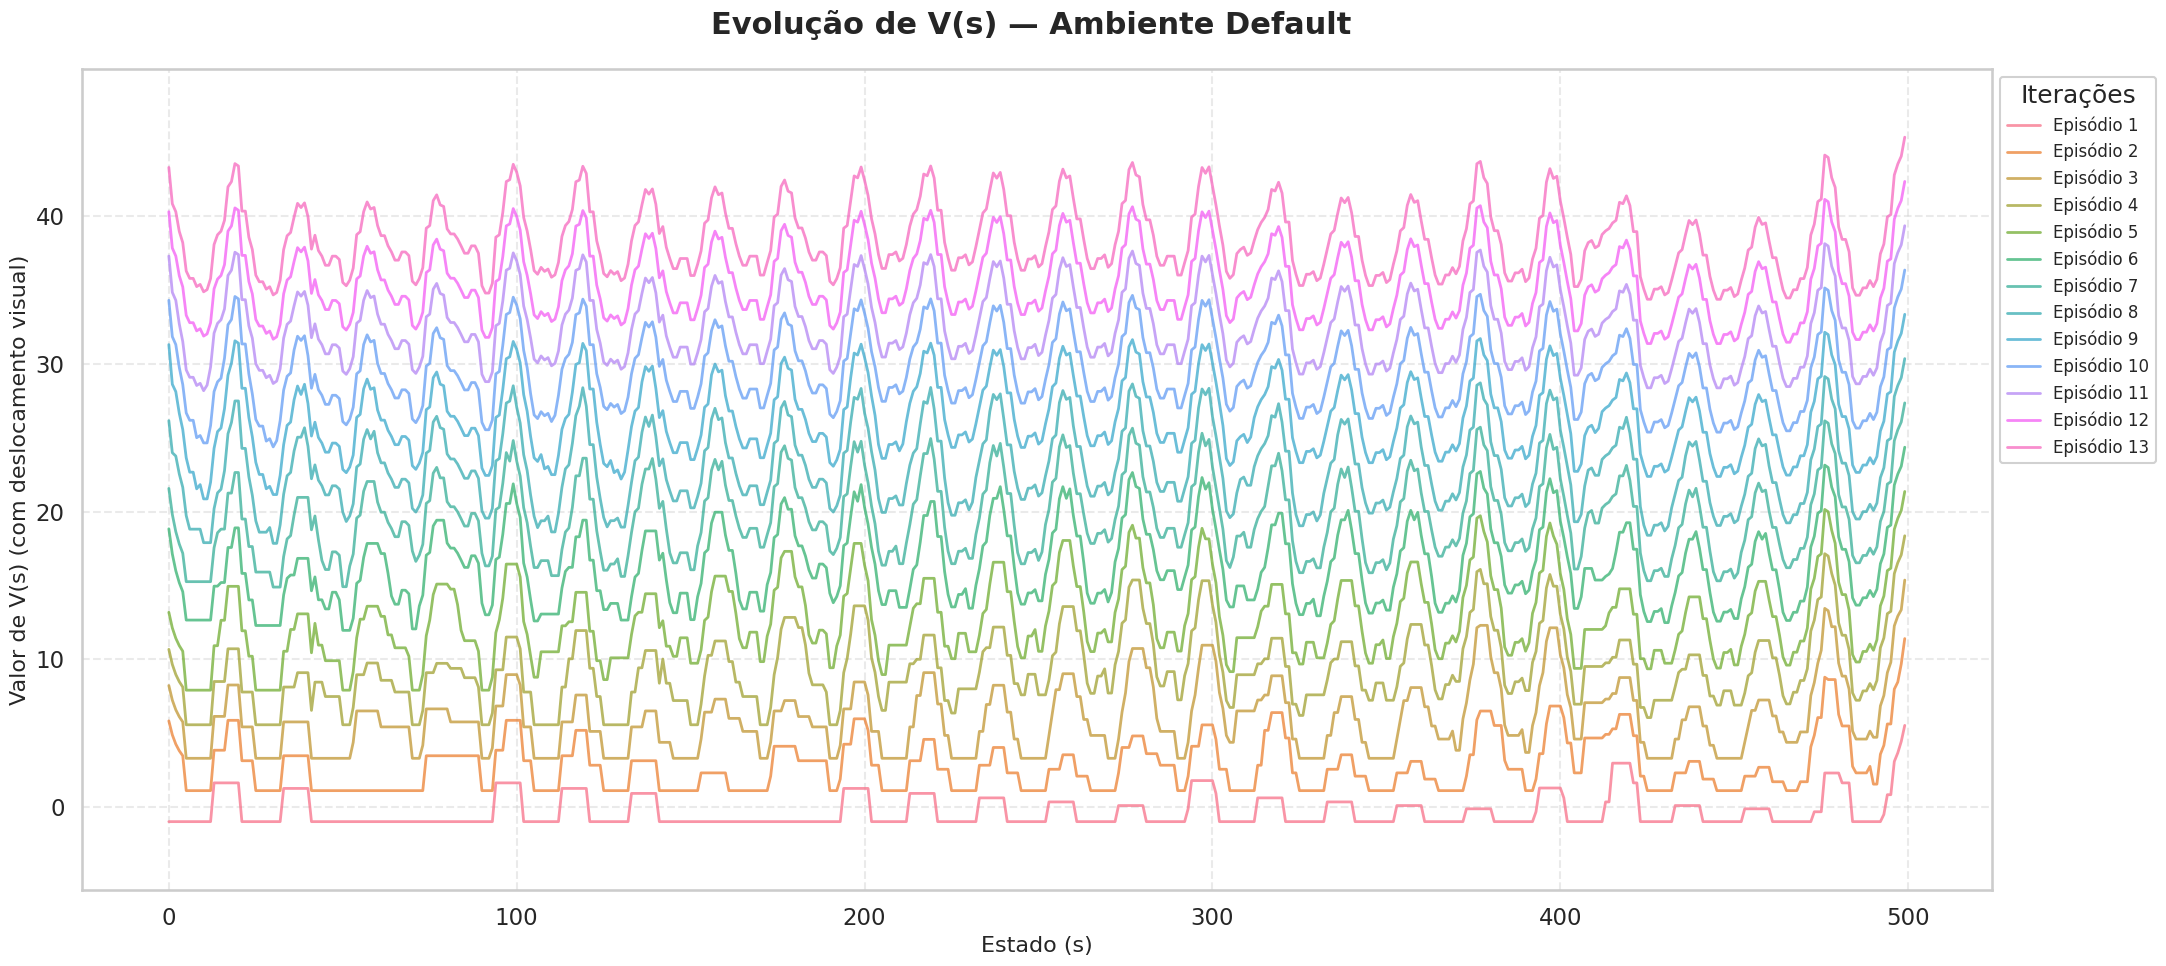

Iteração 1: Valor médio de V(s) = -0.3103
Iteração 2: Valor médio de V(s) = -0.2096
Iteração 3: Valor médio de V(s) = -0.0810
Iteração 4: Valor médio de V(s) = 0.2940
Iteração 5: Valor médio de V(s) = 0.6029
Iteração 6: Valor médio de V(s) = 1.2522
Iteração 7: Valor médio de V(s) = 1.5183
Iteração 8: Valor médio de V(s) = 1.8749
Iteração 9: Valor médio de V(s) = 2.2299
Iteração 10: Valor médio de V(s) = 2.3771
Iteração 11: Valor médio de V(s) = 2.4567
Iteração 12: Valor médio de V(s) = 2.4679
Iteração 13: Valor médio de V(s) = 2.4679


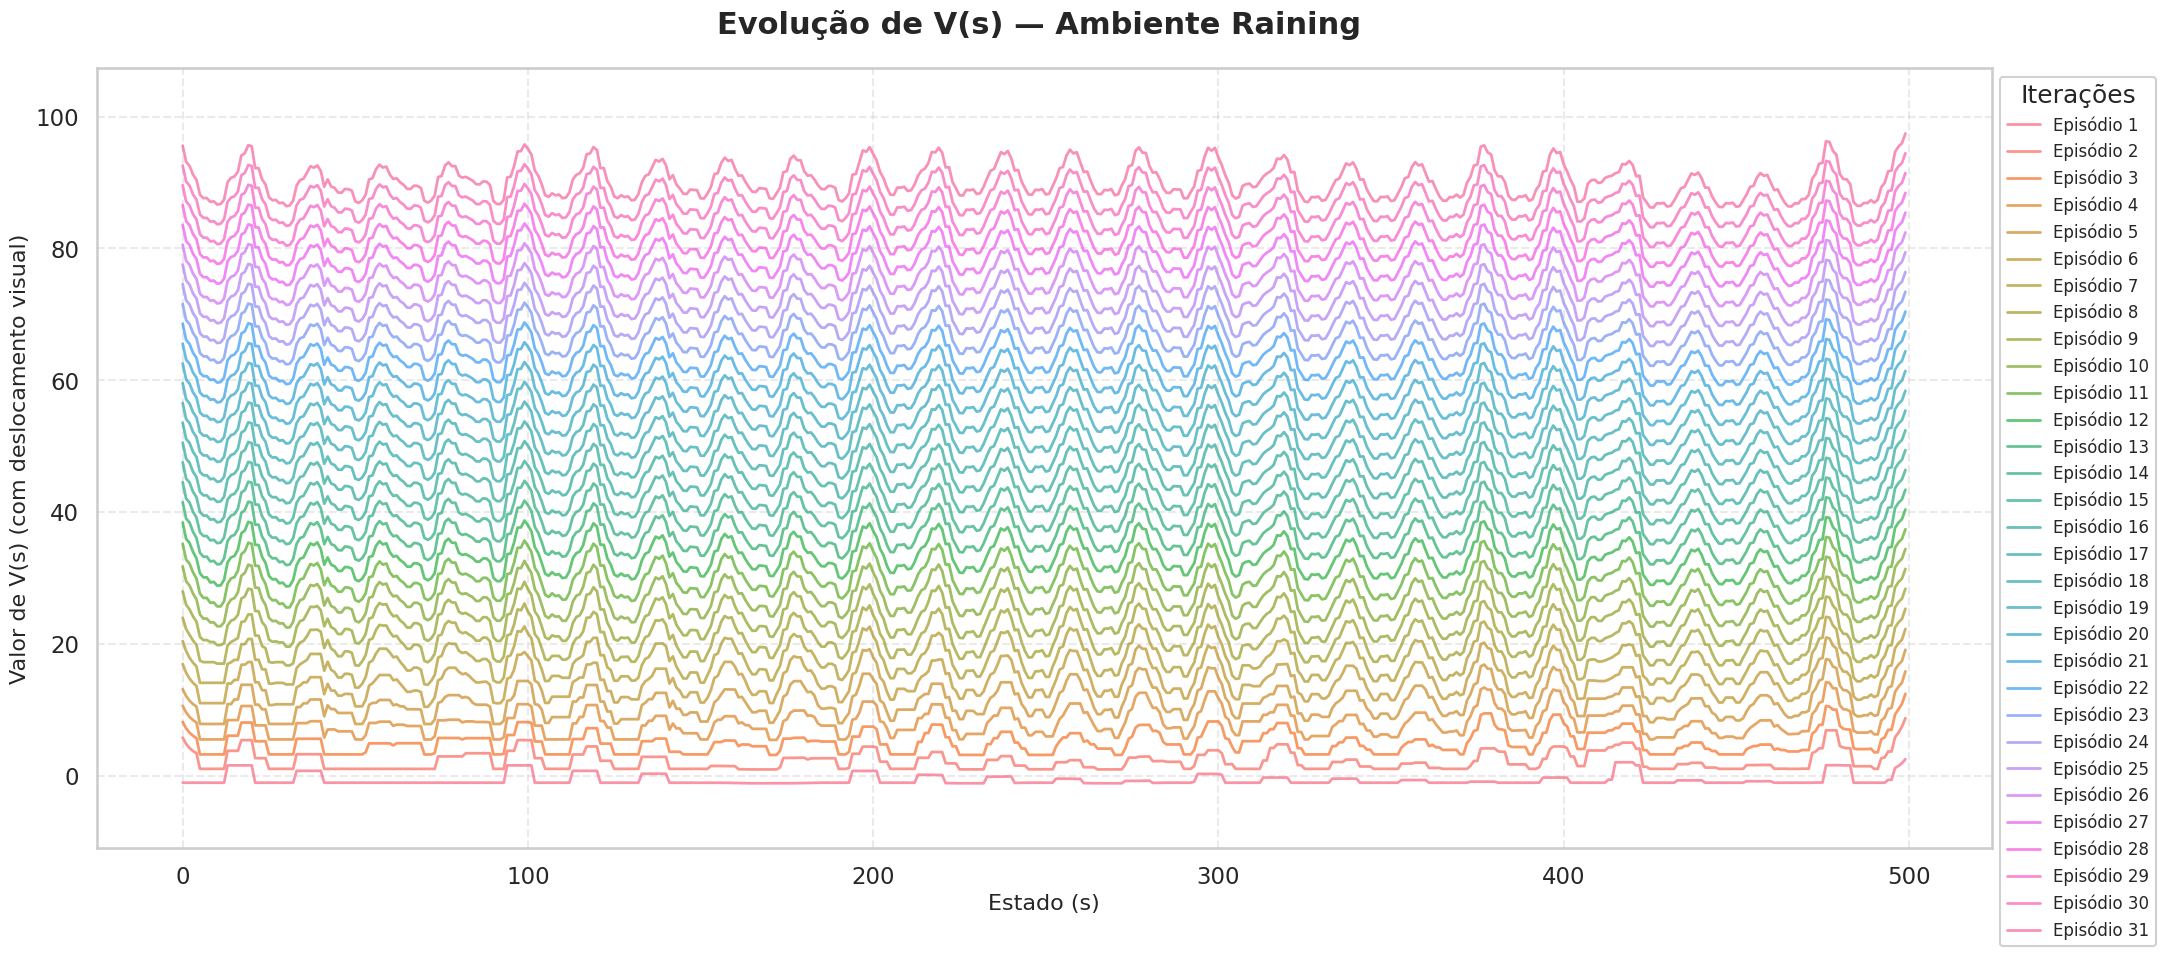

Iteração 1: Valor médio de V(s) = -0.5664
Iteração 2: Valor médio de V(s) = -0.7252
Iteração 3: Valor médio de V(s) = -0.8601
Iteração 4: Valor médio de V(s) = -0.8892
Iteração 5: Valor médio de V(s) = -0.8305
Iteração 6: Valor médio de V(s) = -0.6801
Iteração 7: Valor médio de V(s) = -0.5102
Iteração 8: Valor médio de V(s) = -0.3643
Iteração 9: Valor médio de V(s) = -0.2417
Iteração 10: Valor médio de V(s) = -0.1292
Iteração 11: Valor médio de V(s) = -0.0215
Iteração 12: Valor médio de V(s) = 0.0753
Iteração 13: Valor médio de V(s) = 0.1501
Iteração 14: Valor médio de V(s) = 0.1994
Iteração 15: Valor médio de V(s) = 0.2280
Iteração 16: Valor médio de V(s) = 0.2431
Iteração 17: Valor médio de V(s) = 0.2506
Iteração 18: Valor médio de V(s) = 0.2540
Iteração 19: Valor médio de V(s) = 0.2556
Iteração 20: Valor médio de V(s) = 0.2562
Iteração 21: Valor médio de V(s) = 0.2565
Iteração 22: Valor médio de V(s) = 0.2566
Iteração 23: Valor médio de V(s) = 0.2567
Iteração 24: Valor médio de V(s)

In [10]:
# Plotando a evolução de V(s) para o ambiente padrão
plot_evolucao_V(df_default,"Default")

# Plotando a evolução de V(s) para o ambiente com chuva
plot_evolucao_V(df_raining,"Raining")

## Execução Agente Dentro de Ambiente

A partir desta análise inicial vamos inicializar a implementação prática de nosso agente em execução

In [ ]:
def q_learning(env, num_episodes=700, max_steps=200, alpha=0.1, gamma=0.9, epsilon=0.1,start_reward=10):
    
    """
    Q-learning tabular para ambientes discretos (Taxi-v3).
    Retorna a tabela Q e a lista de recompensas por episodio.
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    episode_rewards = []
    
    for ep in range(num_episodes):
        obs, info = env.reset()
        total_reward =  start_reward

        for t in range(max_steps):
            # Epsilon-greedy
            if np.random.rand() < epsilon:
                a = env.action_space.sample()
            else:
                a = int(np.argmax(Q[obs]))
            next_obs, reward, terminated, truncated, info = env.step(a)
            done = terminated or truncated
            # Q-learning update (off-policy)
            best_next = np.max(Q[next_obs])
            Q[obs, a] = Q[obs, a] + alpha * (reward + gamma * best_next * (not done) - Q[obs, a])
            obs = next_obs
            total_reward += reward
            if done:
                break
        episode_rewards.append(total_reward)
    return Q, episode_rewards


In [12]:
def q_policy(Q):
    """
    Deriva uma política a partir da tabela Q.
    """
    return np.argmax(Q, axis=1)


In [13]:
# Executando o treinamento com Q-learning no ambiente padrão
Q_default, rewards_default = q_learning(env_default, num_episodes=700, max_steps=200, alpha=0.1, gamma=0.9, epsilon=0.1,start_reward=10)

# Executando o treinamento com Q-learning no ambiente com chuva
Q_raining, rewards_raining = q_learning(env_raining, num_episodes=700, max_steps=200, alpha=0.1, gamma=0.9, epsilon=0.1,start_reward=10)

In [14]:
print(q_policy(Q_default))
print("")
print(q_policy(Q_raining))

[0 4 4 4 0 0 3 3 0 1 0 3 1 2 1 0 5 0 0 0 0 5 3 3 2 0 1 2 3 0 0 2 1 2 1 0 3
 0 2 0 0 1 2 2 1 0 0 1 5 3 0 2 3 0 0 0 0 2 4 5 0 2 3 1 3 0 1 2 0 0 0 1 2 0
 1 0 0 2 0 0 0 2 3 2 4 0 4 4 2 3 0 1 2 3 2 0 0 5 0 0 0 1 1 1 3 0 2 0 0 1 0
 2 0 1 3 0 1 0 0 2 0 3 3 2 3 0 1 1 1 4 0 1 3 3 2 0 3 0 3 0 0 2 1 1 1 0 3 1
 3 1 0 1 1 3 0 0 0 2 0 2 0 2 1 0 2 0 1 2 2 0 0 0 3 1 1 0 0 2 0 0 0 3 1 3 1
 0 1 1 1 0 0 0 3 3 2 0 0 1 3 3 0 1 1 1 1 0 3 1 0 1 0 0 3 1 0 0 1 2 0 2 0 0
 1 1 1 0 1 2 3 3 0 3 1 2 0 0 3 2 3 2 0 1 3 1 2 0 1 3 2 2 0 1 1 2 0 0 3 1 3
 2 0 3 1 3 0 0 3 3 2 1 0 0 0 0 0 0 3 1 3 0 0 0 2 0 1 0 3 1 3 3 0 0 1 0 1 0
 3 1 3 3 0 2 1 0 0 0 2 0 0 0 0 0 0 0 0 0 1 1 0 1 0 2 2 2 0 0 2 1 0 3 0 1 1
 0 2 0 1 0 1 1 0 2 0 0 2 0 3 3 0 1 0 3 2 3 2 0 1 1 3 1 0 1 1 3 3 0 2 0 0 2
 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 3 3 0 2 0 0 2 0 3 0 3 1 3 3 0 0 2 0 2 0 0
 0 4 4 0 4 3 2 2 0 1 1 5 1 0 3 1 1 0 0 2 2 3 2 0 3 0 0 3 0 3 0 0 3 0 1 0 2
 0 0 1 0 0 0 0 0 3 2 2 0 2 0 3 1 0 0 1 1 0 0 3 3 2 3 0 3 4 4 4 0 1 1 1 5 0
 1 2 0 3 0 2 3 1 0 0 0 3 

In [23]:
from gymnasium.wrappers import RecordVideo, RecordEpisodeStatistics

def record_evaluate_agent(env_to_wrap, policy, num_eval_episodes=20):
    """
    Avalia uma POLÍTICA (policy) em um ambiente Gym, 
    gravando vídeos e estatísticas.
    """
    
    env = RecordVideo(
        env_to_wrap,
        video_folder="taxi",
        name_prefix="eval",
        episode_trigger=lambda x: True
    )
    env = RecordEpisodeStatistics(env, buffer_length=num_eval_episodes)

    print(f"Iniciando avaliação com {num_eval_episodes} episódios...")
    print(f"Vídeos serão salvos em: taxi")

    for episode_num in range(num_eval_episodes):
        obs, info = env.reset()
        done = False
        
        # Loop do episódio de avaliação (SEM TREINAMENTO AQUI)
        while not done:
            # USA A POLÍTICA: Escolhe a melhor ação aprendida
            action = policy[obs] 
            
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

    print("Avaliação concluída.")
    env.close()

    # Imprime as estatísticas coletadas pelo wrapper
    print(f'\nResumo da Avaliação:')
    print(f'Recompensas dos episódios: {list(env.return_queue)}')
    print(f'Duração dos episódios (passos): {list(env.length_queue)}')

    # Calcula métricas úteis
    avg_reward = np.mean(env.return_queue)
    std_reward = np.std(env.return_queue)
    avg_length = np.mean(env.length_queue)

    print(f'\nRecompensa média: {avg_reward:.2f} ± {std_reward:.2f}')
    print(f'Duração média: {avg_length:.1f} passos')

In [24]:
record_evaluate_agent(env_default, q_policy(Q_default), num_eval_episodes=4)

Iniciando avaliação com 4 episódios...
Vídeos serão salvos em: taxi
Avaliação concluída.

Resumo da Avaliação:
Recompensas dos episódios: [-200.0, -200.0, -200.0, 11.0]
Duração dos episódios (passos): [200, 200, 200, 10]

Recompensa média: -147.25 ± 91.37
Duração média: 152.5 passos


In [ ]:
# Aplicar fimcap SA